In [1]:
import os, sys

sys.path.insert(0, os.path.abspath('..'))
os.environ['USE_PYGEOS'] = '0'

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

True

In [5]:
import geemap, ee
import pandas as pd
from shapely.geometry import shape
from shapely.geometry import Polygon
import uuid
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [21]:
from shapely.geometry import box, MultiPolygon

In [4]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [6]:
india = gpd.read_file("/data/sand_mining/shapefiles/India_Country_Boundary.shp")
india_main = india[india.Area == india.Area.max()].copy()
india_main = india_main.to_crs('EPSG:4326')

In [7]:
ee_fc = geemap.geopandas_to_ee(india)

In [9]:
# fishnet = geemap.fishnet(ee_fc, h_interval=0.025, v_interval=0.25)

In [18]:
polygon = india_main.geometry.values[0]
resolution_x = 0.05
resolution_y = 0.05

# Calculate bounding box of the polygon
minx, miny, maxx, maxy = polygon.bounds

# Generate arrays of coordinates
x_coords = np.arange(minx, maxx, resolution_x)
y_coords = np.arange(miny, maxy, resolution_y)

# Create meshgrid of coordinates
x, y = np.meshgrid(x_coords, y_coords)

# Flatten and stack coordinates to create polygons
polygons = [box(x, y, x + resolution_x, y + resolution_y) for x, y in zip(x.flatten(), y.flatten())]


In [26]:
import multiprocessing as mp
cpus = mp.cpu_count()

In [40]:
def get_poly(poly, master = polygon):    
    if poly.intersects(master):
        return poly

<Axes: >

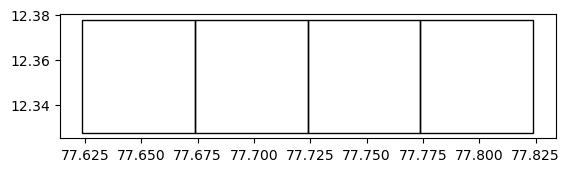

In [36]:
gpd.GeoDataFrame(geometry = list(map(get_poly, [(p, polygon) for p in polygons[50000:50004]]))).plot(facecolor = 'None')

In [58]:
pool = mp.Pool(processes = cpus//2)
results = pool.map(get_poly, polygons)
pool.close()
pool.join()

In [74]:
final_df = gpd.GeoDataFrame(geometry = results)
final_df.crs = {'init' :'epsg:4326'}
final_df = final_df.dropna()

/home/suraj.nair/.conda/envs/rv-21/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [106]:
final_df['id'] = range(1, len(final_df)+1)
final_df.drop(columns = 'centroid').to_file("/data/sand_mining/grids/india_005.shp")

In [81]:
final_df['centroid'] = final_df.centroid

/tmp/ipykernel_2415854/962050766.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  final_df['centroid'] = final_df.centroid


In [84]:
final_df['centroid_x'] = final_df['centroid'].x
final_df['centroid_y'] = final_df['centroid'].y



final_df[['id', 'centroid_x', 'centroid_y']].to_csv("/data/sand_mining/grids/india_005.csv", index = False)

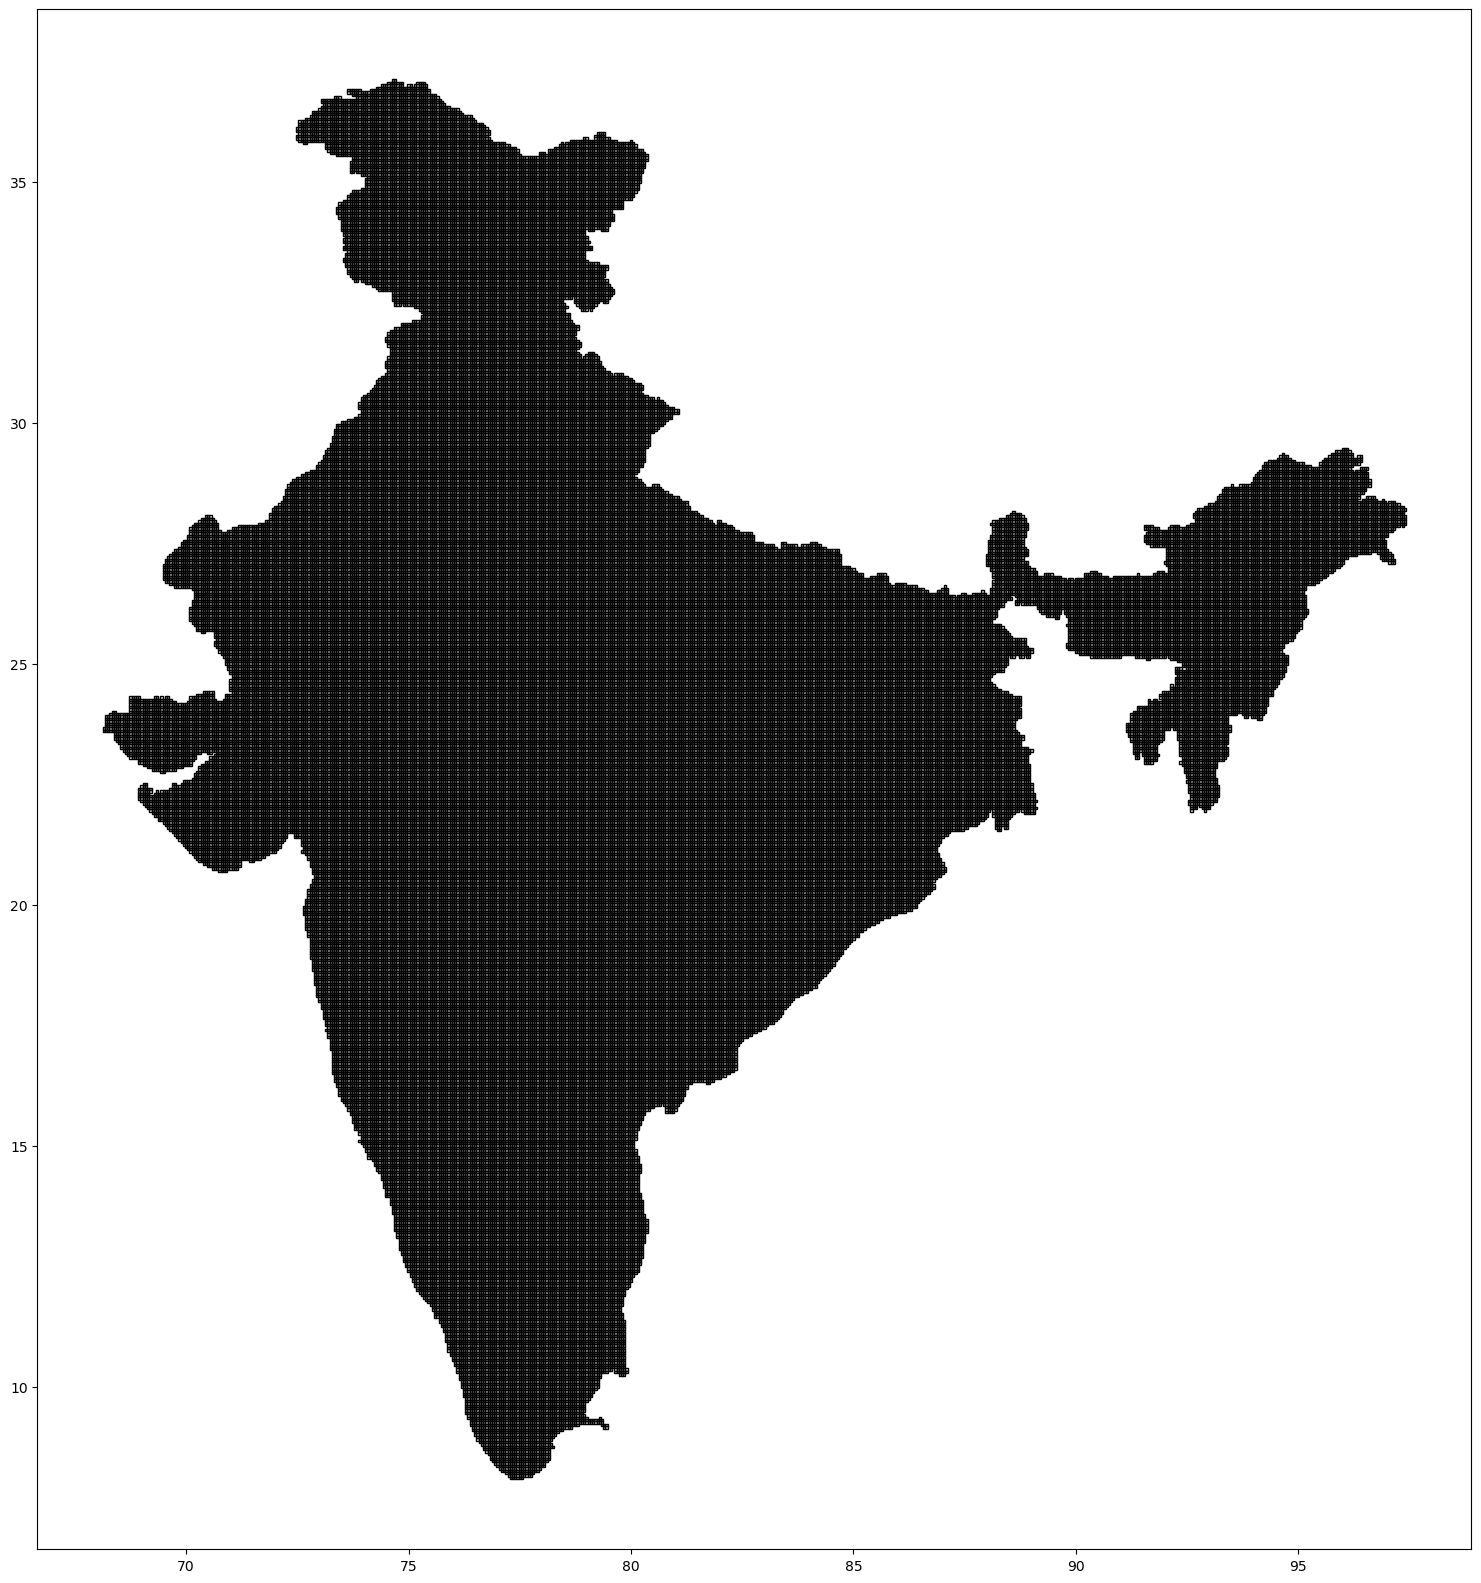

In [78]:
import gc
gc.collect()

fig, ax = plt.subplots(figsize = (20, 20))
final_df.plot(ax = ax, facecolor = 'None')
plt.show()

In [90]:
#### Load files
sone = gpd.read_file("/data/sand_mining/rivers/sone_polygon.geojson")

/tmp/ipykernel_2415854/2705575300.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  sone_grids = gpd.sjoin(final_df, sone[:1], predicate = 'intersects')


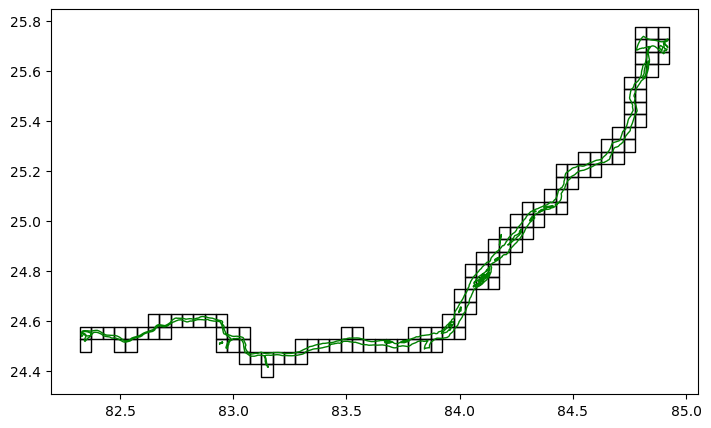

In [103]:
sone_grids = gpd.sjoin(final_df, sone[:1], predicate = 'intersects')

fig, ax = plt.subplots(figsize = (10, 5))
sone_grids.plot(ax = ax, facecolor = 'None')
sone.plot(ax = ax, facecolor = 'None', edgecolor = 'green')
plt.show()